In [48]:
import matplotlib
import matplotlib.pyplot as plt
import accbpg

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# Суть эксперимента

Рассмотрим алгоритм Франка-Вульфа для шага вида
$$\alpha_k = \alpha_k(L) := \min \{ -\frac{\nabla f(x_k)^\top d_k}{L ||d_k||^2_2}, 1 \}$$


Мы показали, что если функция обладает свойством относительной гладкости, то для метода Франка-Вульфа с  шагом вида:
$$\alpha_k = \alpha_k(L) := \min \{ (\frac{-\nabla f(x_k)^\top d_k}{2 L V(s^k, x^k)})^{1/(\gamma - 1)}, 1 \}$$
, где $V$ - дивергенция Брегмана, $1 < \gamma \leq 2$ - степень из свойства Triangle Scaling Exponent https://arxiv.org/pdf/1808.03045.pdf


Сравним скорость сходимости данного метода по сравнению с другими методами из статьи https://arxiv.org/pdf/1808.03045.pdf

## Постановка задачи
Solve the D-Optimal experiment design problem
$$
\begin{array}{ll}
\textrm{minimize}   & F(x):=\log\left(\det\left(\sum_{i=1}^n x_i V_i V_i^T\right)\right) \\
\textrm{subject to} & \sum_{i=1}^n x_i = 1, \\ 
                    & x_i\geq 0, \quad i=1,\ldots,n
\end{array}
$$
where $V_i\in R^m$ for $i=1,\ldots,n$.

Methods compared:
* Adaptive Frank-Wolfe method with $\alpha_k$ step size
* Bregman Proximal Gradient (BPG) method with adaptive line search
* Accelerated Bregman Proximal Gradient (ABPG) method with gain adaption
* ABPG method with exponent adaptation (ABPG-e)
* ABPG method with gain adaptation (ABPG-g)

Эксперимент: n=200, m=80

Алгоритм Франка-Вульфа с относительной гладкостью до точности примерно 1e-2 сошёлся быстрее конкурентов. Однако после этой границы ускоренные алгоритмы ABPG-e и ABPG-g добиваются более высоких точностей и продолжают улучшать точность особенно алгоритм ABPG-g  

Если для задачи достаточно точности 1e-2, то желательно предпочтесть наш алгоритм

In [53]:
# Generate a random instance of the D-optimal design problem of size m by n
maxitrs = 5000
m = 80
n = 200
f, h, L, x0Kh = accbpg.D_opt_design(m, n)
x0KY = accbpg.D_opt_KYinit(f.H)
x0 = (1 - 1e-3) * x0KY + 1e-3 * x0Kh

x00, F00, G00, T00 = accbpg.BPG(f, h, L, x0, maxitrs=maxitrs, linesearch=True, ls_ratio=2, verbskip=100, verbose=False)
x10, F10, G10, T10 = accbpg.ABPG(f, h, L, x0, gamma=2.0, maxitrs=maxitrs, theta_eq=True, verbskip=100, verbose=False)
x00_fw, F00_fw, G00_fw, T00_fw = accbpg.FW_alg_div_step(f, h, L, x0, lmo=accbpg.lmo_simplex(), maxitrs=maxitrs, gamma=2.0, ls_ratio=2, verbskip=100, verbose=False)
x2e, F2e, Gamma2e, G2e, T2e = accbpg.ABPG_expo(f, h, L, x0, gamma0=3, maxitrs=maxitrs, theta_eq=True, Gmargin=100, verbskip=1000, verbose=False)
x2g, F2g, G2g, Gdiv2g, Gavg2g, T2g = accbpg.ABPG_gain(f, h, L, x0, gamma=2, maxitrs=maxitrs, G0=0.1, theta_eq=True, verbskip=1000, verbose=False)

C:\Users\alexa\AppData\Local\Temp\ipykernel_1520\4163054121.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 1, 1)


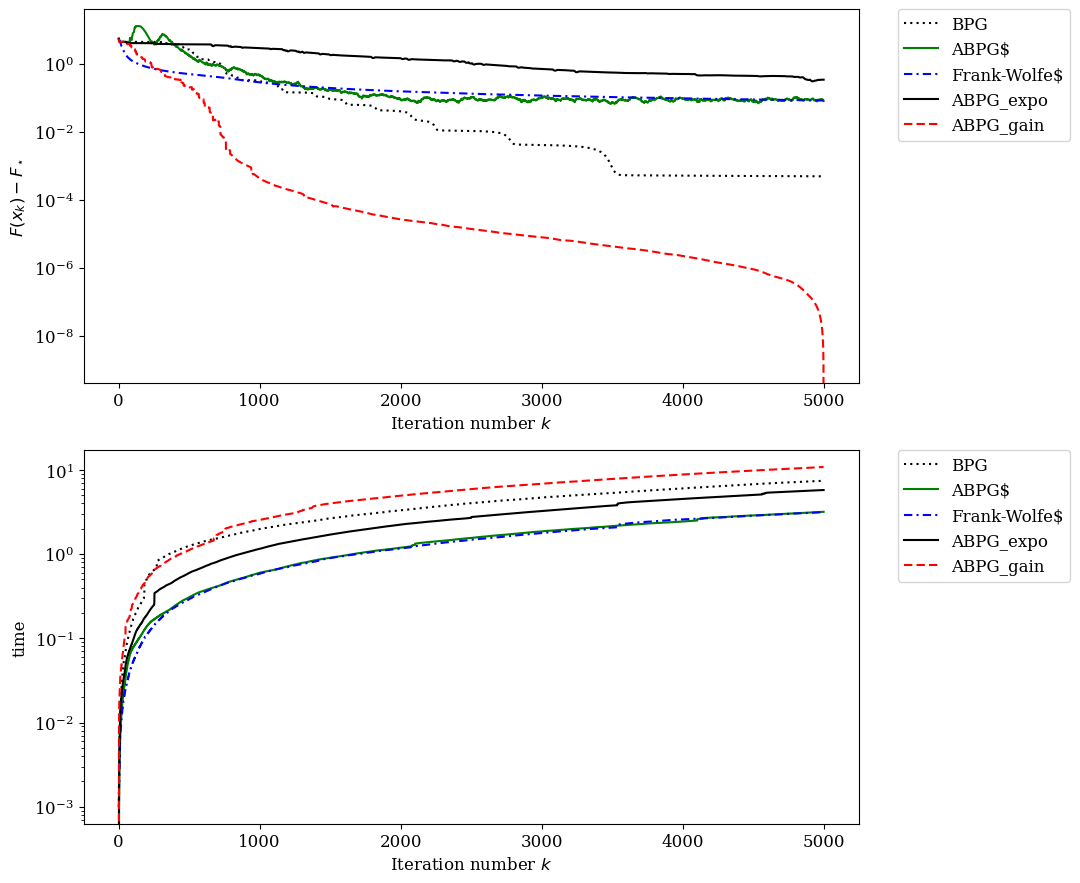

In [55]:
# Plot the objective gap and estimated gains for triangle scaling
fig, _ = plt.subplots(1, 2, figsize=(11, 9))

labels = [r"BPG", r"ABPG$", r"Frank-Wolfe$", r"ABPG_expo", r"ABPG_gain"]
styles = ['k:', 'g-', 'b-.', 'k-', 'r--']
dashes = [[1, 2], [], [4, 2, 1, 2], [], [4, 2]]

ax1 = plt.subplot(2, 1, 1)
y_vals = [F00, F10, F00_fw, F2e, F2g]
accbpg.plot_comparisons(ax1, y_vals, labels, x_vals=[], plotdiff=True, yscale="log",
                        xlabel=r"Iteration number $k$", ylabel=r"$F(x_k)-F_\star$", legendloc="outside",
                        linestyles=styles, linedash=dashes)

ax2 = plt.subplot(2, 1, 2)
y_vals = [T00, T10, T00_fw, T2e, T2g]
accbpg.plot_comparisons(ax2, y_vals, labels, x_vals=[], plotdiff=False, yscale="log", xlabel=r"Iteration number $k$", ylabel=r'time', legendloc="outside",  linestyles=styles, linedash=dashes)

plt.tight_layout(w_pad=4)
plt.show()

Эксперимент: n=2000, m=800

Тут алгоритмы ABPG-e и ABPG-g проявили себя очень плохо, так как в них много вычислений, которые переполняют стэк и выдают некорректные значения

В силу простоты реализации алгоритм FW проявляет себя на задаче размерности n=2000 сильно лучше, однако после 500 итерации BPG начинает сходиться быстрее

In [57]:
max_itrs = 1000

m = 800
n = 2000
f, h, L, x0Kh = accbpg.D_opt_design(m, n)
x0KY = accbpg.D_opt_KYinit(f.H)
x0 = (1 - 1e-3) * x0KY + 1e-3 * x0Kh

x01, F01, G01, T01 = accbpg.BPG(f, h, L, x0, maxitrs=max_itrs, linesearch=True, ls_ratio=2, verbskip=100)
x11, F11, G11, T11 = accbpg.ABPG(f, h, L, x0, gamma=2.0, maxitrs=max_itrs, theta_eq=True, verbskip=100)
x01_fw, F01_fw, G01_fw, T01_fw = accbpg.FW_alg_div_step(f, h, L, x0, lmo=accbpg.lmo_simplex(), maxitrs=max_itrs, gamma=2.0, ls_ratio=2, verbskip=100)
x12e, F12e, Gamma12e, G12e, T12e = accbpg.ABPG_expo(f, h, L, x0, gamma0=3, maxitrs=max_itrs, theta_eq=True, Gmargin=100, verbskip=1000)
x12g, F12g, G12g, Gdiv12g, Gavg12g, T2g2 = accbpg.ABPG_gain(f, h, L, x0, gamma=2, maxitrs=max_itrs, G0=0.1, theta_eq=True, verbskip=1000)


BPG_LS method for min_{x in C} F(x) = f(x) + Psi(x)
     k      F(x)         Lk       time
     0   2.436e+02   5.000e-01     0.1
   100   2.426e+02   1.250e-01    19.7
   200   2.425e+02   1.250e-01    39.3
   300   2.419e+02   2.500e-01    58.2
   400   2.198e+02   1.250e-01    75.8
   500   1.911e+02   1.250e-01    92.8
   600   1.859e+02   1.250e-01   108.4

ABPG method for minimize_{x in C} F(x) = f(x) + Psi(x)
     k      F(x)       theta        TSG       D(x+,y)     D(z+,z)     time
     0   2.436e+02   1.000e+00   1.000e+00   2.414e-01   2.414e-01     0.0
   100   4.566e+02   1.924e-02   4.837e+02   2.667e+03   1.490e+04    11.4
   200         inf   9.801e-03   1.358e+03   1.844e+03   1.414e+04    22.7
   300         inf   6.578e-03   1.042e+03   7.999e+02   1.774e+04    34.0
   400         inf   4.950e-03   3.043e+02   1.439e+03   1.930e+05    46.0
   500         inf   3.968e-03   8.741e-01   2.345e-05   1.704e+00    57.7
   600         inf   3.311e-03   7.789e+01   2.274e+02

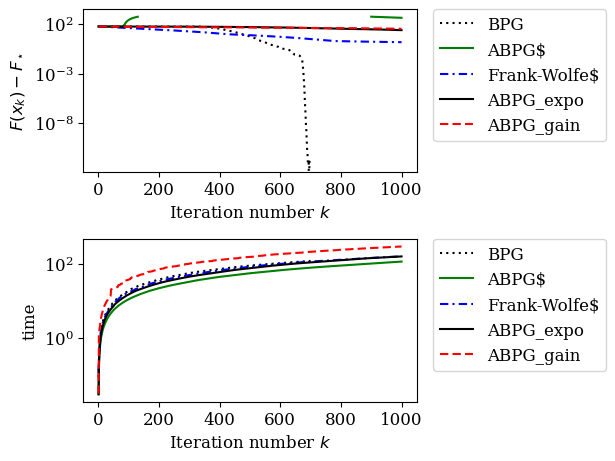

In [62]:
ax1 = plt.subplot(2, 1, 1)
y_vals = [F01, F11, F01_fw, F12e, F12g]
accbpg.plot_comparisons(ax1, y_vals, labels, x_vals=[], plotdiff=True, yscale="log",
                        xlabel=r"Iteration number $k$", ylabel=r"$F(x_k)-F_\star$", legendloc="outside",
                        linestyles=styles, linedash=dashes)

ax2 = plt.subplot(2, 1, 2)
y_vals = [T01, T11, T01_fw, T12e, T2g2]
accbpg.plot_comparisons(ax2, y_vals, labels, x_vals=[], plotdiff=False, yscale="log", 
                        xlabel=r"Iteration number $k$", ylabel=r'time', legendloc="outside",
                        linestyles=styles, linedash=dashes)

plt.tight_layout(w_pad=4)
plt.show()